# Оптимизация потребления электроэнергии предприятия на этапе обработки стали

Некоторый металлургический комбинат рещил оптимизировать расход электроэнергии. Для этого заказчик поставил перед нами следующую цель: **добиться определенного уровня метрики MAE для температуры, являющейся целевым признаком, на тестовых данных модели, которую нам также необходимо построить**.  Весь процесс заключается в том, что расплавленный металл подогревают электродами (изначально плавят), добавляют легирующие добавки (как правило, в несколько этапов), продувют газом для равномерного перемешивания.

В резуьтате должны быть решены такие задачи как:
- анализ полученных данных;
- грамотное построение датасета для дальнейшего моделирования;
- создание моделей и выбор наиболее подходящей по метрике (MAE не более 6.8 на тесте).

Для выполнения этих задач следует придерживаться такого плана (он в целом соответствует самим задачам):
- проанализировать полученные данные. Учитывая, что мы имеем несколько таблиц, будет хорошо, если получится сразу определиться с тем, какие данные будут признаками, какие целевым признаком и как максимально корректно сформировать из них датафрейм для будующей модели. Т.е. после рассмотрения данных уже стоит определиться с направлением, что делать, а что нет;
- провести исследование данных. Здесь стоит избавиться от выбросов (единственный замер, отрицательная реактивная тяга, температура ниже 1500 градусов), отследить полезные зависимости в перспективе (если возможно, построить новые признаки), заменить (избавиться от) пропуски, провести небольшой статистический анализ и т.п. В итоге нужно будет объединить данные по ключу, построить корреляционную матрицу по требованию заказчика;
- построить несколько моделей, из которых определить наиболее эффективную. Последнюю проверить на тестовых данных и сравнить с константной моделью;
- написать отчет по работе. Где необходимо описать: все предпринятые шаги, проблемы при их выполнении, методы устраннеия, саму итоговую модель со всеми использованными признакми, сходимость плана и решения.

Для решения задачи в нашем распоряжении набор данных с информацией о подаче разных материалов  в расплав (объем, время), измерениях температуры, электродах.

## Анализ данных

Сначала импортируем ряд библиотек, которые могут пригодиться при выполнении проекта:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn import svm
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, make_scorer, get_scorer, mean_absolute_error
from catboost import cv, CatBoostRegressor, Pool
from scipy import stats as st
from tqdm import tqdm
from sklearn.dummy import DummyRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

Откроем все файлы для дальнейшего рассмотрения.

In [2]:
try:
    data_arc = pd.read_csv('data_arc_new.csv')
except:
    data_arc = pd.read_csv('/YP/data_arc_new.csv')

try:
    data_bulk = pd.read_csv('data_bulk_new.csv')
except:
    data_bulk = pd.read_csv('/YP/data_bulk_new.csv')
    
try:
    data_bulk_t = pd.read_csv('data_bulk_time_new.csv')
except:
    data_bulk_t = pd.read_csv('/YP/data_bulk_time_new.csv')
    
try:
    data_gas = pd.read_csv('data_gas_new.csv')
except:
    data_gas = pd.read_csv('/YP/data_gas_new.csv')
    
try:
    data_temp = pd.read_csv('data_temp_new.csv')
except:
    data_temp = pd.read_csv('/YP/data_temp_new.csv')
    
try:
    data_wire = pd.read_csv('data_wire_new.csv')
except:
    data_wire = pd.read_csv('/YP/data_wire_new.csv')
    
try:
    data_wire_t = pd.read_csv('data_wire_time_new.csv')
except:
    data_wire_t = pd.read_csv('/YP/data_wire_time_new.csv')

Проведем первичный анализ для понимания содержимого.

In [3]:
data_arc.info()
data_arc.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [4]:
data_arc['key'].nunique()

3214

In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Уникальных ключей меньше где-то в 4 раза, очевидно, что для большинства выполнялось несколкьо замеров.  Явно имеются выбросы в реактивной мощности.

In [6]:
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [7]:
#data_bulk.describe()

В целом понятно, что в большиснтве случаев используются только добавки 3, 4, 12, 14, 15.

In [8]:
data_bulk_t.info()
data_bulk_t.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Получается, что данная таблица, скорее всего нам не пригодится - для нас приоритетом будет, какая добавка введена и сам факт её наличия.

In [9]:
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [10]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [11]:
data_gas['key'].nunique()

3239

Минимальное значение столбца Газ 1 кажется слишком маленьким, но с другой стороны, мы не знаем единиц измерения и что там подразумевалось.

In [12]:
data_temp.info()
data_temp.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [13]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


В целом получается что первый (самый ранний) key, а точнеее температура для него, по времени может послужить признаком, а конечная (последняя для данного значения key) целевым признаком. Последний замер (по первым трем key) сделан после окончания работы электродов и введения добавок (это, конечно, лучше провериить на всех данных), что в целом для нас хорошо, и логика испльзования объемов проволочных и сыпучих материалов в качестве признаков не нарушается.

Имеются значения температуры ниже 1500. Стандартное отклонение не очень большое, очевидно, что температура варьируется не сильно.

In [14]:
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь также, как и в табл. bulk имеется немного столбцов, обозначающих активное использование соответствующих добавок - большинство с пропусками.

In [15]:
data_wire_t.info()
data_wire_t.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


По всей вилдимости, при решении мы также сможем обойтись без учета этой таблицы. По ней по крайней мере видно, что wire 1 (смотрим для первых строк) было использовано именно во время вклюяения, выключения электродов.

В результате можем определиться с видом нашего датафрейма для модели, в котором в качестве признаков стоит выделить:
- активную мощность (попробуем среднее по замерам для одного ключа);
- объемы сыпучих материалов (NaN заменим на 0);
- обхемы проволочных материалов (NaN заменим на 0);
- данные о продувке газом;
- будет неплохо попробовать ввести какой-то свой признак.

*По реактивной тяги поищем аномалии, для начала учитывать как признак ее не будем. Также логично будет по итогу избавиться от столбцов bulk и wire, в которых ненулевых записей меньше 200.*

## Исследовательский анализ

Рассмотрим по отдельности все таблицы, данные которых планируется и использовать и проанализируем.

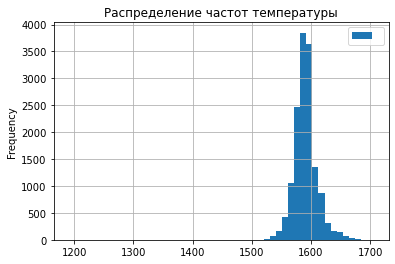

In [16]:
data_temp.plot(kind='hist', y='Температура', bins=50, grid=True, label='')
plt.title('Распределение частот температуры')
plt.show()

В целом распределение температур подчиняется нормальному закону, если не учитывать выбросы. От них нам необходимо избавиться, но предварительно отберем только минимальные и максимальные значения по времени при этом отбросим партии с единственным замером.

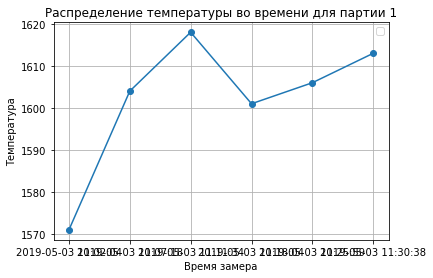

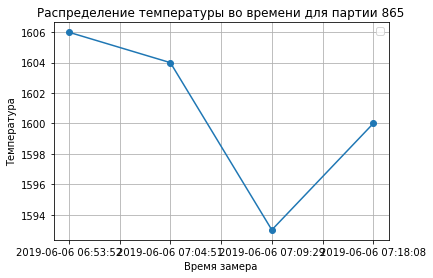

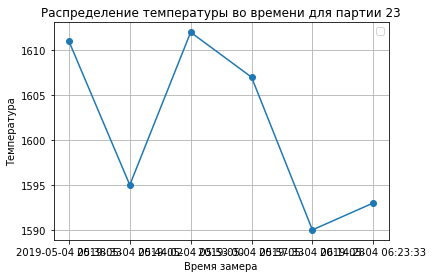

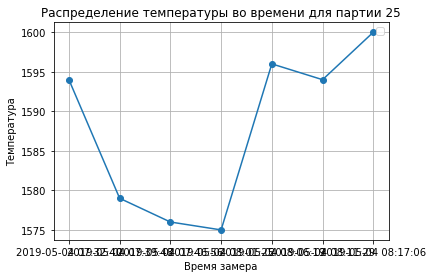

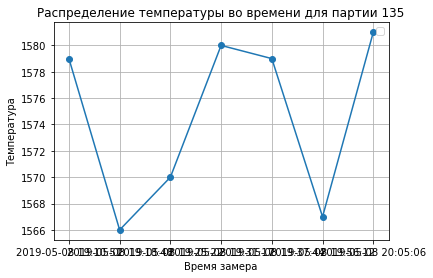

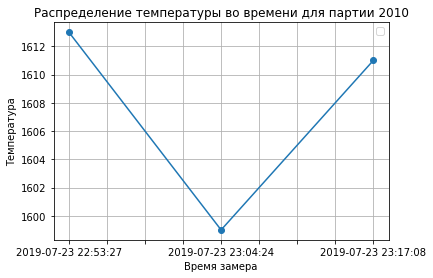

In [17]:
keys_m = [1, 865, 23, 25, 135, 2010]
# keys_m - набор любых ключей из фрейма с температурами
for i in range(len(keys_m)):
    data_temp.loc[data_temp['key'] == keys_m[i]].plot(kind='line', x='Время замера',
                                                      y='Температура', ylabel='Температура', marker = 'o')
    plt.grid(True)
    plt.legend('')
    plt.title('Распределение температуры во времени для партии ' + str(keys_m[i]))
    plt.show()

Заметно, что при замерах для одной партии температура колеблется по-разному. В целом где-то падает, где-то расет.

In [18]:
tenp_gr = data_temp.groupby(['key']).agg({'Температура': 'count'})
tenp_gr = tenp_gr.loc[tenp_gr['Температура'] > 1]
tenp_gr = tenp_gr.rename(columns={'Температура': 'Т'})
tenp_gr

,Т
key,
1,6
2,5
3,6
4,5
5,5
...,...
2495,5
2496,7
2497,4


Сделали временную таблицу, где избавились от партий, в которых делался один замер. Теперь в оставшихся найдем самый ранний и самый поздний замер для партии.

Дабы нигде не ошибиться, подвергнувшись мнению, что у нас в датафрейме и так все отсортировано, как надо, проведем разброс и повторную сортировку данных.

In [19]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp = data_temp.sample(frac=1, random_state=80523)
data_temp = data_temp.sort_values(['key', 'Время замера'])
data_temp.head(17)


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [20]:
temp_gr1 = data_temp.groupby(['key']).agg({'Время замера': 'min', 'Температура': 'first'})
temp_gr2 = data_temp.groupby(['key']).agg({'Время замера': 'max', 'Температура': 'last'})

In [21]:
temp_gr2

,Время замера,Температура
key,,
1,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:36:39,1602.0
...,...,...
3237,2019-09-06 11:55:45,1569.0
3238,2019-09-06 12:34:37,1584.0
3239,2019-09-06 15:09:55,1598.0


Работает, по всей видимости, верно. Далее объединим временные таблицы так, чтобы и единичных замеров для партии не осталось.

In [22]:
temp_gr1 = tenp_gr.join(temp_gr1, how='left')
temp_gr2 = tenp_gr.join(temp_gr2, how='left')
temp_gr1 = temp_gr1.drop(columns=['Т'])
temp_gr2 = temp_gr2.drop(columns=['Т'])

In [23]:
display(temp_gr1)
temp_gr2

,Время замера,Температура
key,,
1,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:11:03,1576.0
...,...,...
2495,2019-08-10 11:27:47,1570.0
2496,2019-08-10 11:56:48,1554.0
2497,2019-08-10 12:37:26,1571.0


,Время замера,Температура
key,,
1,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:36:39,1602.0
...,...,...
2495,2019-08-10 11:50:47,1591.0
2496,2019-08-10 12:25:13,1591.0
2497,2019-08-10 12:53:28,1589.0


Похоже на реальность. Проверим на наличие 'пустот' или NaN.

In [24]:
print('Чичло пустых ячеек при группировке 1:', pd.isnull(temp_gr1['Температура']).sum())
print('Чичло пустых ячеек при группировке 2:', pd.isnull(temp_gr2['Температура']).sum())

Чичло пустых ячеек при группировке 1: 0
Чичло пустых ячеек при группировке 2: 0


In [25]:
print('Чичло дубликатов при группировке 1:', temp_gr1.duplicated().sum())
print('Чичло дубликатов при группировке 2:', temp_gr2.duplicated().sum())

Чичло дубликатов при группировке 1: 0
Чичло дубликатов при группировке 2: 0


Себя же на адекватность проверили, похоже все верно. Переименуем колонки, чтобы потом объединить таблицы

In [26]:
#temp_gr1 = temp_gr1.rename(columns={'Температура': 'Температура н'})
#temp_gr2 = temp_gr2.rename(columns={'Температура': 'Температура к'})
temp_gr1.columns = ['Время замера н', 'Температура н']
temp_gr2.columns = ['Время замера к', 'Температура к']

In [27]:
data_temp1 = temp_gr1.join(temp_gr2, how='outer')

In [28]:
data_temp1

,Время замера н,Температура н,Время замера к,Температура к
key,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...
2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0
2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0
2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0


посмотрим распределение температур во времени (время начала и конца очень замеров для партии близкие, отобразим все на одной оси Х)

1588.4020202020201
1595.3361616161617


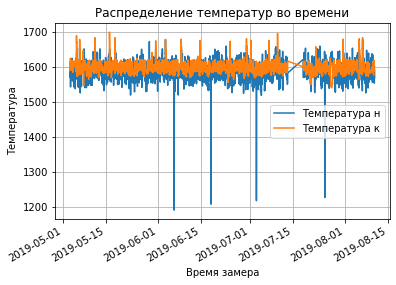

In [29]:
#fig = plt.figure(figsize=(10, 8))
ax = data_temp1.plot(kind='line', x='Время замера н', y='Температура н')
data_temp1.plot(kind='line', x='Время замера к', y='Температура к', ax=ax)
plt.grid(True)
ax.set_ylabel('Температура')
ax.set_xlabel('Время замера')
plt.title('Распределение температур во времени')
print(data_temp1['Температура н'].mean())
print(data_temp1['Температура к'].mean())

У графиков разные оси Х, поэтому отображение может быть не совсем корректным, но на таком масштабе очень похоже на истину. Отчетливо видны выбросы и отсутствие плаки (или просто внесения замеров) в определенный промежуток времени. Видно, что в среднем при последнем замере температура была несколько выше.

Создадим общий датафрейм, где будем хранить информацию для модели

In [30]:
data_full = data_temp1[['Температура н', 'Температура к']]
data_full = data_full.reset_index()
data_full = data_full.astype('int16')
data_full.tail()

,key,Температура н,Температура к
2470,2495,1570,1591
2471,2496,1554,1591
2472,2497,1571,1589
2473,2498,1591,1594
2474,2499,1569,1603


In [31]:
data_full.loc[(data_full['Температура н'] < 1500) | (data_full['Температура к'] < 1500)].count()

key              4
Температура н    4
Температура к    4
dtype: int64

Выбросы по температуре остались, избавимся от них.

In [32]:
data_full = data_full.loc[(data_full['Температура н'] >= 1500) & (data_full['Температура к'] >= 1500)]

Таким образом, мы полностью почистили датафрейм с температурами и подготовили его к дальнейшей раюоте, сформировав признак (столбец "Температура н") и целевой признак (столбец "Температура к").

Перейдем к таблице data_arc. Избавимся от выбросов и оставим только те ключи, что фигурируют в data_full.

In [33]:
data_arc = data_arc.loc[data_arc['Реактивная мощность'] > 0]

In [34]:
data_arc = data_arc.loc[data_arc['key'].isin(data_full['key'])]

Построим графики распределения мощностей при нагревах для некоторых выборочных партий

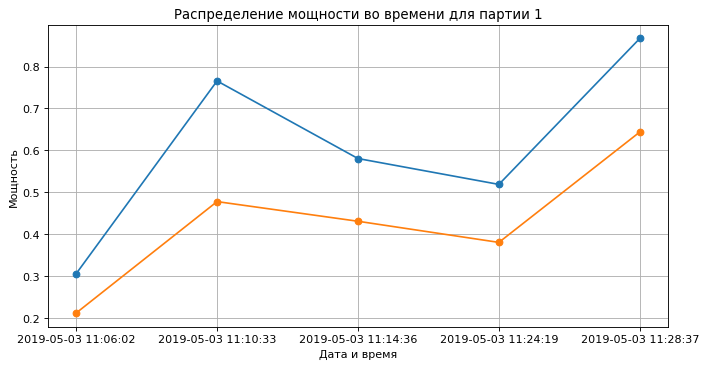

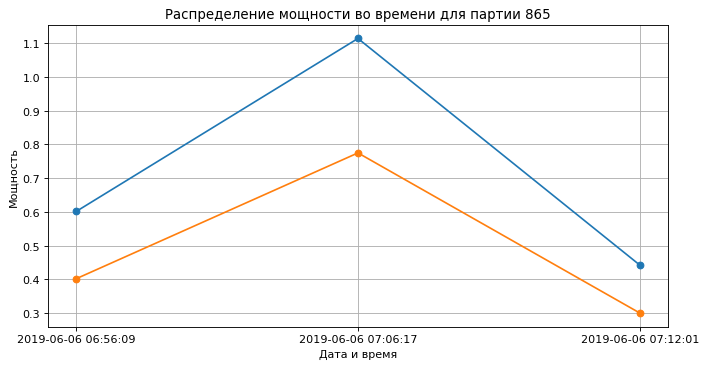

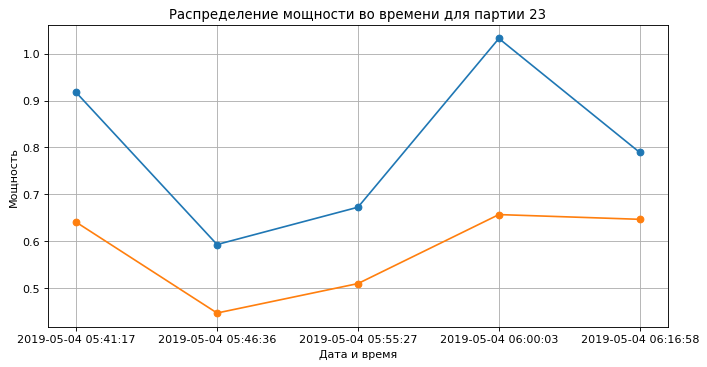

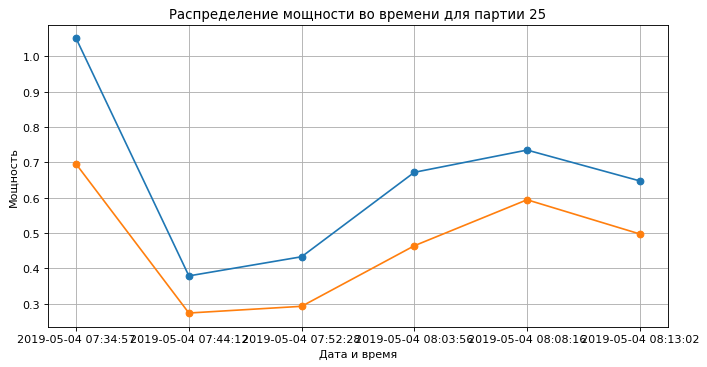

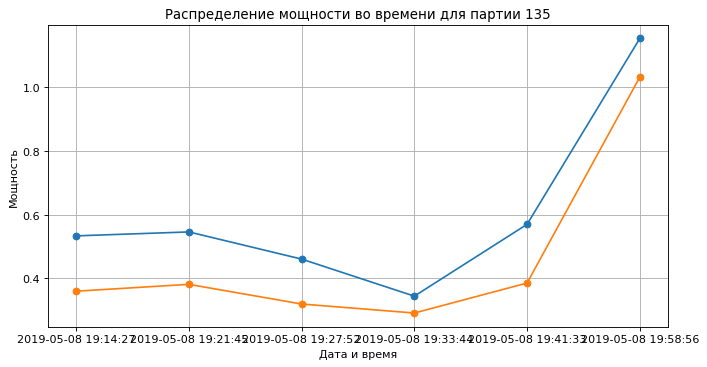

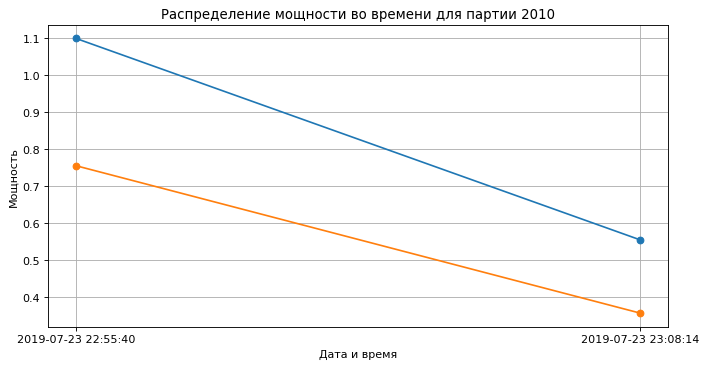

In [35]:
for i in range(len(keys_m)):
    plt.figure(figsize=(10, 5), dpi=80)
    temp = data_arc.loc[data_arc['key'] == keys_m[i]]
    plt.plot(temp['Конец нагрева дугой'], temp['Активная мощность'], marker = 'o')
    plt.plot(temp['Конец нагрева дугой'], temp['Реактивная мощность'], marker = 'o')
    #data_arc.loc[data_arc['key'] == keys_m[i]].plot(kind='line', x='Конец нагрева дугой',
                                                      #y=['Активная мощность', 'Реактивная мощность'], ylabel='Мощность', marker = 'o')
    plt.grid(True)
    plt.xlabel('Дата и время')
    plt.ylabel('Мощность')
    plt.title('Распределение мощности во времени для партии ' + str(keys_m[i]))
    plt.show()

По графикам понятно, что разница между активной и реактивной мощностью всегда положительна, а также то, что для партии эта разница в целом может меняться. Факт отсутствия константности может пригодиться ниже - есть вариант попробовать создать новый признак на основе этих двух мощностей.

Данная таблица больше всего интересна тем, что здесь можно попробовать вывести новые признаки для последующего МО. К примеру, полную мощность и работу (реактивную мощность затем можно удалить). Приведем данные исходной таблицы  к удобому типу, рассчитаем время нагрева электродугой для каждой из записей.

Тогда работу найдем по формуле:

$$ A = P * t,$$

где $P$ - активная мощность;
$t$ - время нагрева.

В таком случае полную мощность можно найти из схемы:

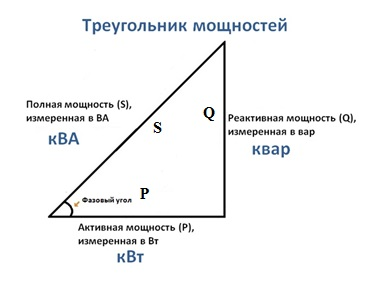

$$ S = \sqrt{Q ^ 2 + P ^ 2} $$

где $Q$ - реактивная мощность.

А некий коэффициент мощности, определяющий сдвиг тока по фазе:

$$ cos \phi = \frac{P} {S} $$

In [36]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [37]:
data_arc['delta_time'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

In [38]:
data_arc['delta_time'] = data_arc['delta_time'].dt.total_seconds().astype('int32')

In [39]:
data_arc['cur_operation'] = data_arc['delta_time'] * data_arc['Активная мощность']
data_arc['cur_power'] = np.sqrt(data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2)
#data_arc['cos_fi'] = data_arc['Активная мощность'] / data_arc['cur_power'] 
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,delta_time,cur_operation,cur_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,69.569640,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,141.646730,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,99.813836,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,189.251040,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,128.335684,1.079934
...,...,...,...,...,...,...,...,...
11444,2498,2019-08-10 13:20:18,2019-08-10 13:20:59,0.508786,0.363916,41,20.860226,0.625538
11445,2499,2019-08-10 13:33:31,2019-08-10 13:38:43,0.700677,0.534767,312,218.611224,0.881433
11446,2499,2019-08-10 13:41:44,2019-08-10 13:45:09,0.333776,0.269695,205,68.424080,0.429117
11447,2499,2019-08-10 13:46:38,2019-08-10 13:51:33,0.406252,0.263303,295,119.844340,0.484117


In [40]:
data_arc_gr = data_arc.groupby(['key']).agg({'Активная мощность': 'mean', 
                                            'cur_operation': 'mean',
                                            'cur_power': 'mean',
                                            #'cos_fi': 'mean',
                                             'Реактивная мощность': 'count',
                                            'delta_time': 'sum'})
data_arc_gr = data_arc_gr.reset_index()
data_arc_gr.head()

,key,Активная мощность,cur_operation,cur_power,Реактивная мощность,delta_time
0,1,0.607346,125.723386,0.743747,5,1098
1,2,0.534852,98.820450,0.647087,4,811
2,3,0.812728,116.354925,1.003845,5,655
3,4,0.676622,135.927569,0.850010,4,741
4,5,0.563238,103.045120,0.704245,4,869


In [41]:
data_full = data_full.merge(data_arc_gr, on='key', how='inner')
data_full.tail(3)

,key,Температура н,Температура к,Активная мощность,cur_operation,cur_power,Реактивная мощность,delta_time
2468,2497,1571,1589,1.201746,226.775558,1.453639,3,569
2469,2498,1591,1594,0.640462,94.983759,0.781983,5,750
2470,2499,1569,1603,0.434271,106.980638,0.542313,4,883


Опираясь, на вышесказанное, присоединим к итоговой таблице данные о материалах, использующихся в качестве легирующих добавок.

In [42]:
data_bulk1 = pd.DataFrame(data_bulk['key'].copy())
for i in range(data_bulk.shape[1] - 1):
    #условие, что общее количество раз, когда использовался добавка больше 150
    if data_bulk['Bulk ' + str(i + 1)].count() > 150:
        data_bulk1['Bulk ' + str(i + 1)] = data_bulk['Bulk ' + str(i + 1)]

data_bulk1 = data_bulk1.fillna(0)
data_bulk1 = data_bulk1.astype('int32')
data_bulk1

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0,0,43,0,0,0,206,150,154
1,2,0,0,73,0,0,0,206,149,154
2,3,0,0,34,0,0,0,205,152,153
3,4,0,0,81,0,0,0,207,153,154
4,5,0,0,78,0,0,0,203,151,152
...,...,...,...,...,...,...,...,...,...,...
3124,3237,0,170,0,0,0,0,252,130,206
3125,3238,0,126,0,0,0,0,254,108,106
3126,3239,0,0,0,114,0,0,158,270,88
3127,3240,0,0,0,26,0,0,0,192,54


In [43]:
data_wire1 = pd.DataFrame(data_wire['key'].copy())
for i in range(data_wire.shape[1] - 1):
    #cnt = data_bulk['Bulk ' + str(i + 1)].count()
    if data_wire['Wire ' + str(i + 1)].count() > 150:
        data_wire1['Wire ' + str(i + 1)] = data_wire['Wire ' + str(i + 1)]

data_wire1 = data_wire1.fillna(0)
data_wire1 = data_wire1.astype('int32')
data_wire1

,key,Wire 1,Wire 2
0,1,60,0
1,2,96,0
2,3,91,0
3,4,89,0
4,5,89,9
...,...,...,...
3076,3237,38,0
3077,3238,56,0
3078,3239,143,0
3079,3240,34,0


В таблице data_gas не было пропущенной информации.

In [44]:
data_gas.duplicated().sum()

0

Дубликатов тоже нет.

Ниже приведен код для самопроверки, после всех объединений. data_bulk1 и data_wire1 не содержат некоторых ключей, которые есть в data_full, поэтому после послднего объединения наша итоговая таблица несколько уменьшится в размере. В следующей ячейке как раз расчитывается, на сколько строк должен уменьшится data_full

In [45]:
dif_size1 = data_full.loc[~data_full['key'].isin(data_wire1['key'])]
dif_size2 = data_full.loc[~data_full['key'].isin(data_bulk1['key'])]
dif_size3 = data_full.loc[~data_full['key'].isin(data_gas['key'])]
dif_temp = dif_size1.merge(dif_size2, on='key', how='outer')
dif_temp.merge(dif_size3, on='key', how='outer').shape[0]

146

In [46]:
data_full = data_full.merge(data_bulk1, on='key', how='inner')
data_full = data_full.merge(data_wire1, on='key', how='inner')
data_full = data_full.merge(data_gas, on='key', how='inner')
data_full = data_full.rename(columns={'Активная мощность': 'active_power',
                                     'Температура н': 'temp_start',
                                     'Температура к': 'temp_finish',
                                      'Реактивная мощность': 'measuring_count',
                                     'Газ 1': 'gas',
                                     '': ''})

In [47]:
data_full.info()
data_full.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2325 non-null   int16  
 1   temp_start       2325 non-null   int16  
 2   temp_finish      2325 non-null   int16  
 3   active_power     2325 non-null   float64
 4   cur_operation    2325 non-null   float64
 5   cur_power        2325 non-null   float64
 6   measuring_count  2325 non-null   int64  
 7   delta_time       2325 non-null   int32  
 8   Bulk 1           2325 non-null   int32  
 9   Bulk 3           2325 non-null   int32  
 10  Bulk 4           2325 non-null   int32  
 11  Bulk 6           2325 non-null   int32  
 12  Bulk 10          2325 non-null   int32  
 13  Bulk 11          2325 non-null   int32  
 14  Bulk 12          2325 non-null   int32  
 15  Bulk 14          2325 non-null   int32  
 16  Bulk 15          2325 non-null   int32  
 17  Wire 1        

,key,temp_start,temp_finish,active_power,cur_operation,cur_power,measuring_count,delta_time,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,gas
2320,2495,1570,1591,0.792033,142.884829,0.967180,4,723,0,21,0,0,90,0,256,129,223,89,0,7.125735
2321,2496,1554,1591,0.695820,112.537078,0.845053,6,940,0,0,63,0,122,0,256,129,226,114,0,9.412616
2322,2497,1571,1589,1.201746,226.775558,1.453639,3,569,0,0,85,0,0,0,230,124,226,94,9,6.271699
2323,2498,1591,1594,0.640462,94.983759,0.781983,5,750,0,90,0,0,101,0,206,129,207,118,0,14.953657
2324,2499,1569,1603,0.434271,106.980638,0.542313,4,883,0,47,0,0,0,0,233,126,227,110,50,11.336151


В целом таблица как раз на 146 записей стала меньше.

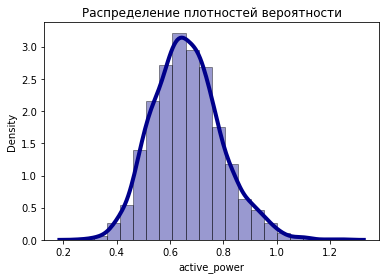

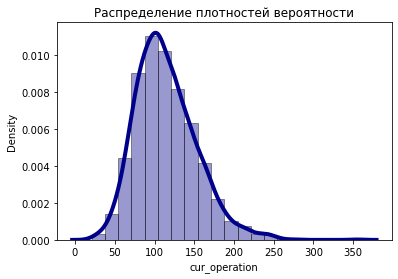

In [48]:
cols = ['active_power', 'cur_operation']
for el in cols:
    sns.distplot(data_full[el], hist=True, kde=True, 
                 bins=20, color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})
    plt.title('Распределение плотностей вероятности')
    plt.show()

Распределения похожи на нормальные, при этом несколько смещены влево (особенно кассается работы). Суммарная площадь под кривой и в том, и в другом случае будет равна 1. Главное отличие в том, что активная можность меняется в узких пределах (размах чуть более 1), а вот работа уже существенный разброс значений от какого-то небольшого значения (20.75) до примерно 350.

Посмотрим, как выглядит распределение добавок bulk и wire, а также общее время нагревания электродугой.

In [49]:
for el in data_full.columns[6:]:
    print(el)

measuring_count
delta_time
Bulk 1
Bulk 3
Bulk 4
Bulk 6
Bulk 10
Bulk 11
Bulk 12
Bulk 14
Bulk 15
Wire 1
Wire 2
gas


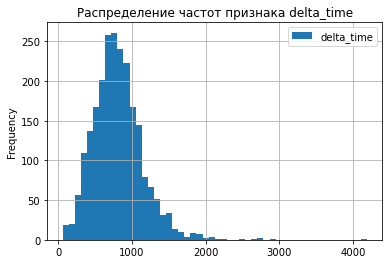

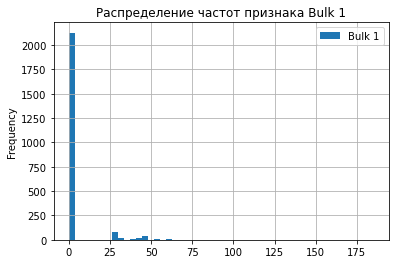

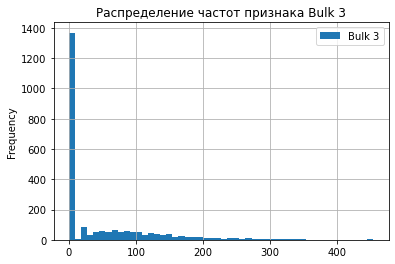

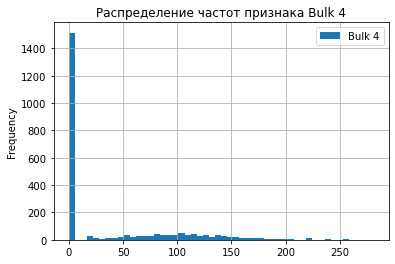

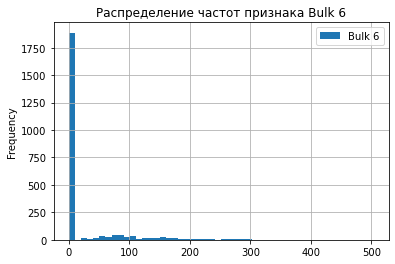

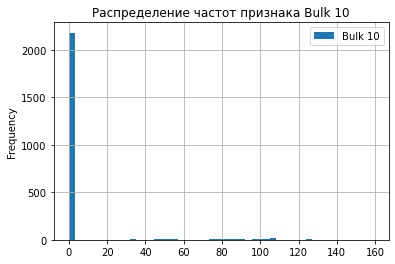

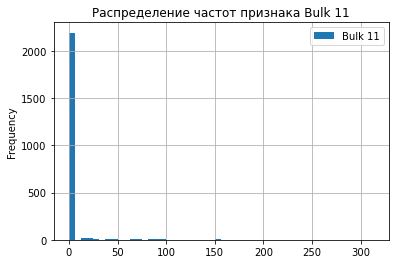

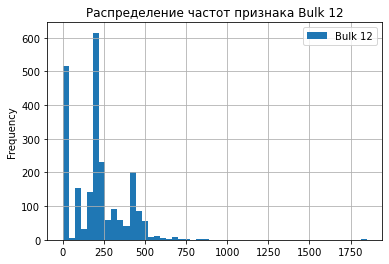

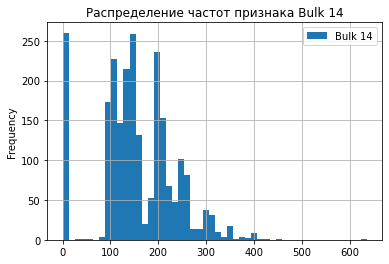

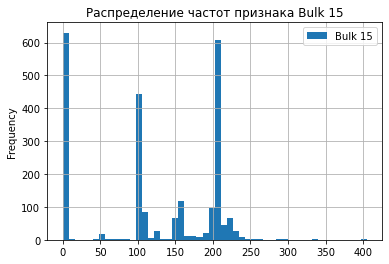

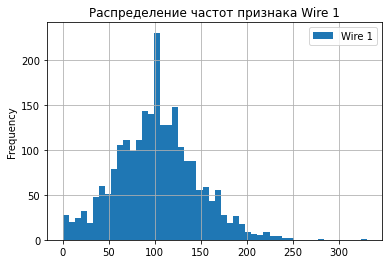

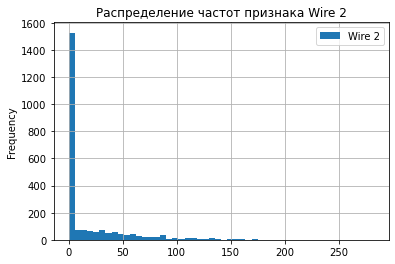

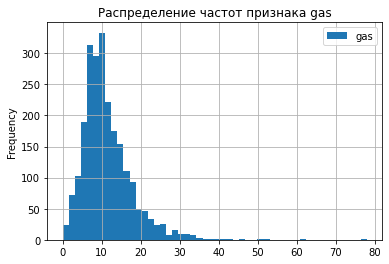

In [50]:
for el in data_full.columns[7:]:
    data_full.plot(kind='hist', y=el, bins=50, grid=True, ylabel=el)
    #plt.set_ylabel(el)
    plt.title('Распределение частот признака ' + str(el))
    plt.show()

Здесь есть несколько очень высоких значений, которые не понятно, стоит ли выбрасывать или нет (в большей степени это касается Bulk 12). В целом если мыслить логически, то можно добавть присадок в расплав раз в 10 больше, чем обычно. 

Поэтому все же удалим несколько сильно выбивающихся значений.

Проверим корреляцию признаков в итоговой таблице.

<AxesSubplot:>

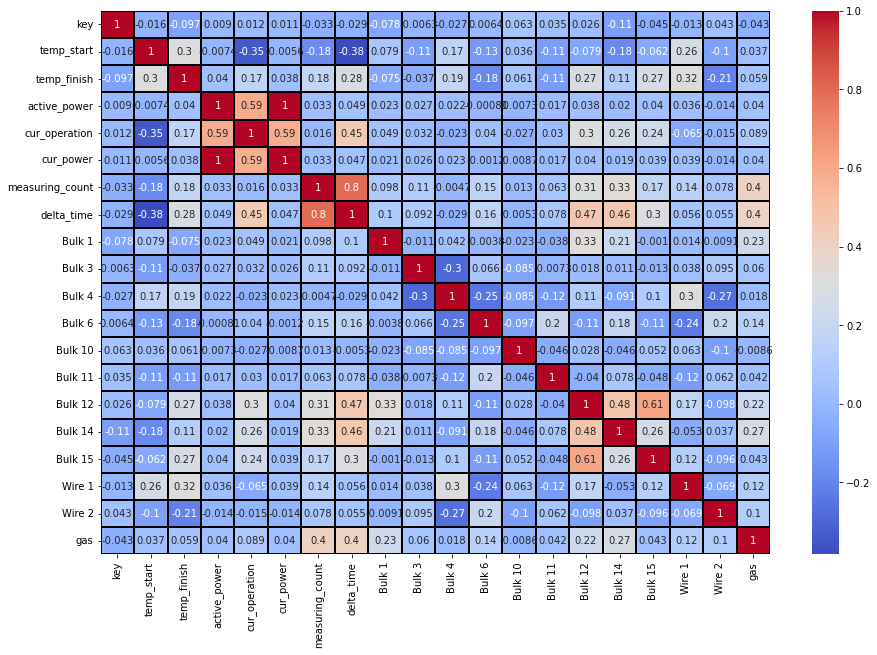

In [51]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(data_full.corr(), linewidths = 0.25, linecolor='black', annot= True, cmap="coolwarm")

**Выводы по разделу**:
- изучена общая информация о данных, хранящихся в нескольких таблицах;
- определены и удалены аномальные значения в выборке;
- построены распределения и графические зависимости некоторых признаков (к примеру, температуры в времени);
- проведена группировка температур по ключу партии и выбор начального и конечного значений во времени;
- из физических соображений выведены два признака: полная мощность и работа при нагреве электродугой;
- все признаки объединены в единую таблицу по ключу партии.

## Построение моделей

### Выделение признаков, предобработка

В принципе ожидаемо полная можность сильно коррелирует с активной. Один из признако нужно удалить.

In [52]:
data_full = data_full.drop(['key', 'active_power', 'measuring_count'], axis=1)

In [53]:
def preprocessing(df):
    df = df.copy()
    features = df.drop(['temp_finish'], axis=1)
    target = df['temp_finish']
    f_valid, f_test, t_valid, t_test = train_test_split(features, target, test_size=0.25, random_state=80523)
    scaler = StandardScaler()
    scaler.fit(f_valid)
    f_valid = scaler.transform(f_valid)
    f_test = scaler.transform(f_test)
    return f_valid, f_test, t_valid, t_test

In [55]:
f_valid, f_test, t_valid, t_test = preprocessing(data_full)
print('Размеры тренировочной и тестоыой выборок:', f_valid.shape, f_test.shape)
print('Размеры целевых признаков ааналогичных выборок', t_valid.shape, t_test.shape)
f_valid

Размеры тренировочной и тестоыой выборок: (1743, 16) (582, 16)
Размеры целевых признаков ааналогичных выборок (1743,) (582,)


array([[ 0.9744131 , -0.31461355,  0.12074182, ...,  0.74614908,
        -0.02146595, -1.45596958],
       [-0.13375928, -0.34326195, -0.77915005, ...,  0.83786704,
        -0.53276634, -1.1360588 ],
       [-0.30424733, -1.76573057, -1.42224184, ..., -0.49204348,
        -0.53276634, -0.57118186],
       ...,
       [ 0.20721684, -0.17041168,  0.38658259, ..., -0.44618449,
        -0.53276634,  0.17037986],
       [ 1.61374332,  0.09661953, -0.04981063, ...,  1.47989281,
        -0.53276634, -0.44445918],
       [ 0.59081497,  0.54957034, -0.14854899, ..., -0.76719738,
        -0.53276634,  1.84030737]])

In [56]:
t_valid.head()

1226    1593
1024    1592
1982    1572
489     1584
130     1618
Name: temp_finish, dtype: int16

### Градиентный бустинг 

Попробуем оценить качество некоторой модели при помощи cv.

In [57]:
params = {
    'loss_function': 'MAE',
    'iterations': 5000,
    'custom_loss': 'MAE',
    'random_seed': 80523,
    'learning_rate': 0.015,
    'l2_leaf_reg': 0.5,
    'grow_policy': 'Depthwise',
    'depth' : 2,
}

'''grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}'''

scores_cv = cv(
    params=params,
    pool=Pool(f_valid, label=t_valid),
    fold_count=5, 
    #shuffle=True, 
    partition_random_seed=80523,
    plot=True, 
    type='Classical',
    #stratified=True, 
    return_models=True,
    verbose=False
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 5.577467248
bestIteration = 4982

Training on fold [1/5]

bestTest = 6.099626491
bestIteration = 4897

Training on fold [2/5]

bestTest = 6.114355812
bestIteration = 4895

Training on fold [3/5]

bestTest = 6.173540587
bestIteration = 2751

Training on fold [4/5]

bestTest = 6.562016052
bestIteration = 1389



In [82]:
scores_cv[0]

,iterations,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std
0,0,1569.338968,0.410082,1569.338508,0.098280
1,1,1545.802700,0.410061,1545.802262,0.098279
2,2,1522.627688,0.409783,1522.626713,0.097754
3,3,1499.796041,0.408907,1499.795671,0.098160
4,4,1477.309967,0.410669,1477.310179,0.096052
...,...,...,...,...,...
4995,4995,6.122142,0.372232,4.663248,0.083344
4996,4996,6.122058,0.372203,4.663068,0.083315
4997,4997,6.122123,0.372147,4.662928,0.083283
4998,4998,6.122169,0.372150,4.662700,0.083318


Отметим неплохую динамику среднего MAE и стандартного отклонения для модели с вышеуказанными параметрами. Если проанализировать график видно, что только на одном тесте лучший результат оказался при относительно небольшом числе итераций. В других же случаях метрика перестала понижаться в диапазоне числа итераций от 3000 до 5000. Из не очень хороших эффектов - высокое стандартное отклонение на тестовых выборках.

Далее все-таки составим модель через использование GridSearchCV.  И напишем функцию вычисления MAE - не хочется по встроенной негативной оценке рассматривать.

In [59]:
def MAE(y, y_pred):
    return sum(abs(y - y_pred)) / len(y)

In [60]:
mae_score = make_scorer(MAE, greater_is_better=False)

Много параметров в grid нигде ставить не будем, иначе скорость выполнения станет очень низкой.

Подбиралось значительно большее количество.

In [61]:
grid = {'depth': [2, 4, 5],
 'iterations': [800, 3500, 4500],
 'l2_leaf_reg': [0.2, 10, 0.05],
 'learning_rate': [0.015, 0.0025, 0.025],
 'loss_function': ['MAE'],
 'random_seed': [80523]}



In [62]:
gbd_cv = GridSearchCV(estimator=CatBoostRegressor(), param_grid=grid, cv=5,
                      scoring=mae_score)
gbd_cv.fit(f_valid, t_valid, verbose=False)
gbd_cv.best_params_

{'depth': 5,
 'iterations': 4500,
 'l2_leaf_reg': 0.05,
 'learning_rate': 0.015,
 'loss_function': 'MAE',
 'random_seed': 80523}

In [64]:
pd.DataFrame(gbd_cv.cv_results_).query('rank_test_score == 1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,param_loss_function,param_random_seed,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
78,9.659661,0.186436,0.005779,0.000745,5,4500,0.05,0.015,MAE,80523,"{'depth': 5, 'iterations': 4500, 'l2_leaf_reg'...",-6.185362,-6.058814,-6.175249,-5.623496,-5.633433,-5.935271,0.254444,1


Посмотрим, лучшие значения средней оценки.

In [65]:
abs(gbd_cv.best_score_)

5.9352709460130795

Неплохо, меньше, чем требования по MAE на тесте, посмотрим далее.  Стандартное отклонение высоковато, но судя по нему, используя даже эту модель (без сравненния с другими) на тесте мы должны уложиться в требования с 90% вероятностью.

Ниже создана модель бустинга с увеличенным числом деревьев и проверена через cross_val_score.

In [67]:
models_gbd = []
gbd = CatBoostRegressor(iterations=4000, max_depth=7, loss_function='MAE', grow_policy= 'Depthwise',
                        learning_rate=0.015, l2_leaf_reg = 0.5, random_state=80523, verbose=False)

models_gbd.append(gbd)

In [68]:
best_model_gbd = None
best_score_gbd = 100

scores_1 = []
scores_1 = abs(cross_val_score(gbd, f_valid, t_valid, cv=5, scoring=mae_score))
final_score = pd.Series(scores_1).mean()
if final_score < best_score_gbd:
    best_score_gbd = final_score
    best_model_gbd = gbd
        
print(best_model_gbd)
print('Result MAE by gradBoosting', best_score_gbd)

Result MAE by gradBoosting 6.033962551561542


Оценка немного ниже в сравнении с gbd_cv.

### Линейная регрессия

Сделаем функцию, которая поможет определить оптимальную степень и число признаков для линейных моделей.

In [70]:
def make_pipe(f_valid, n_comp, degree=1):
    f_valid_pipe = f_valid
    pipe = make_pipeline(PCA(n_components=n_comp), PolynomialFeatures(degree, include_bias=True,
                                                                 interaction_only=False))
    return pipe.fit_transform(f_valid_pipe)

In [71]:
final_score_min = 100
res = []
for n_comp in range(2, f_valid.shape[1] + 1):
    for degree in range(1, 5):
        model_poly = LinearRegression()
        scores = []
        scores = abs(cross_val_score(model_poly, make_pipe(f_valid, n_comp, degree),
                                     t_valid, cv=5, scoring=mae_score))
        final_score = pd.Series(scores).mean()
        #res.append()
        if final_score < final_score_min:
            final_score_min = final_score 
            print('--' * 25)
            print(f"Result MAE by lin_Regr is {final_score} for n_components = {n_comp} and degree = {degree} ")

--------------------------------------------------
Result MAE by lin_Regr is 7.483407854323623 for n_components = 2 and degree = 1 
--------------------------------------------------
Result MAE by lin_Regr is 7.433383155882977 for n_components = 2 and degree = 2 
--------------------------------------------------
Result MAE by lin_Regr is 7.421218306855837 for n_components = 3 and degree = 2 
--------------------------------------------------
Result MAE by lin_Regr is 7.3385755563162745 for n_components = 4 and degree = 2 
--------------------------------------------------
Result MAE by lin_Regr is 7.229409203954225 for n_components = 5 and degree = 2 
--------------------------------------------------
Result MAE by lin_Regr is 7.186993700750231 for n_components = 6 and degree = 2 
--------------------------------------------------
Result MAE by lin_Regr is 7.170975175146279 for n_components = 7 and degree = 2 
--------------------------------------------------
Result MAE by lin_Regr i

Так мы установили наиболее эффективную модель регрессии: 15 признаков - оптимальный вариант.

### Модель ElasticNet

Сделаем через перебор параметров ручным способом.

In [72]:
def make_elastic_models():
    alphas = list(np.logspace(-5, 5, 25))
    l1_ratio = list(np.linspace(0, 1, 8))
    models_elastic = []
    for l1 in l1_ratio:
        for alpha in alphas:
            for i in range(250, 3500, 1000):
                m_r = ElasticNet(max_iter=i, alpha=alpha, l1_ratio=l1, random_state=80523)
                models_elastic.append(m_r)
    return models_elastic

In [73]:
best_model_el = None
best_score_el = 100

for m in tqdm(make_elastic_models()):
    scores_1 = abs(cross_val_score(m, make_pipe(f_valid, 15, 1), t_valid, cv=5, scoring=mae_score))
    scores_1_final = pd.Series(scores_1).mean()
    if scores_1_final < best_score_el:
        best_score_el = scores_1_final
        best_model_el = m
        
print(best_model_el)
print('Result MAE by ElasticNet:', best_score_el)

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:28<00:00, 28.53it/s]

ElasticNet(alpha=0.14677992676220705, l1_ratio=1.0, max_iter=250,
           random_state=80523)
Result MAE by ElasticNet: 6.33178688459525


### Рандомный лес

In [75]:
grid = {"n_estimators": [800, 50],
        #'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [10, 30],
        'max_features': ['sqrt'],
        'min_samples_split': [2, 5],
        #'criterion': ['absolute_error'],
        'random_state': [80523]}

In [76]:
rf_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=5,
                     scoring=mae_score)
rf_cv.fit(f_valid, t_valid)
rf_cv.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 80523}

Лучшая оценка MAE рандомного леса:

In [77]:
m_rf = RandomForestRegressor(max_depth=25, max_features='sqrt', min_samples_split=4,
                             n_estimators=600, random_state=80523)
scores = []
scores = abs(cross_val_score(m_rf , f_valid, t_valid, cv=5, scoring=mae_score))
final_score = pd.Series(scores).mean()
print(final_score)

6.342254036893305


Результаты в целом удовлетворительные (по крайней мере выше константной модели).

### Тестирование лучшей модели

Лучшие результаты в любом случае были в градиентном бустинге. Проверим их на тесте.

In [79]:
preds_gbd = gbd_cv.predict(f_test)
print('Оценка на тесте:', mean_absolute_error(t_test, preds_gbd))

Оценка на тесте: 6.1244863653498225


Напишем константную модель, чтобы можно было сравнить с лучшей из наших.

In [80]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(f_valid, t_valid)
pred_dummy = dummy_regr.predict(f_test)

res_smape_test = mean_absolute_error(t_test, pred_dummy)
print('Оценка MAE константной моделью:', res_smape_test)

Оценка MAE константной моделью: 8.136749255243851


Рассмотрим влияние признаков на модель.

In [81]:
feature_names = data_full.drop(['temp_finish'], axis=1).columns 
importances = gbd_cv.best_estimator_.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([gbd_cv.best_estimator_.feature_importances_ for tree in str(1000)], axis=0)
model_importances


temp_start       19.125222
cur_operation     6.346484
cur_power         3.969081
delta_time       20.456289
Bulk 1            3.860660
Bulk 3            2.227041
Bulk 4            1.975617
Bulk 6            5.469445
Bulk 10           0.871019
Bulk 11           1.666703
Bulk 12           4.289570
Bulk 14           5.655569
Bulk 15           4.230906
Wire 1            9.689149
Wire 2            4.574831
gas               5.592414
dtype: float64

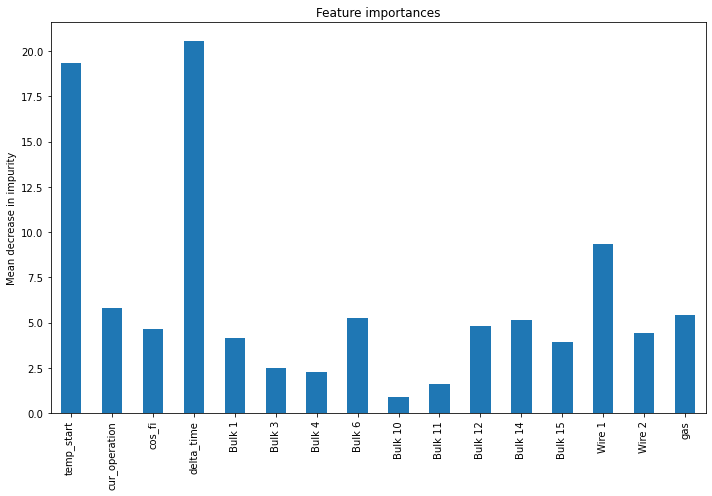

In [447]:
fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Важности некоторых добавок (Bulk 3, Bulk 4) невысока (да и если вспомнить, то, что там было много нулей, это легко объяснимо, но вот столбец gas был без нолей, а его влияние все равно слабое), а вот начальная температура, время нагрева дугой явно вносят существенный вклад в модель (совместно их значимость около 40%)

**Выводы по разделу**
- с помощью кросс-валидации определена наиболее подходящая условиям задачи модель;
- на модели проведен тест, позволяющий говорить, что ее оценки лучше константной модели, а также, что они ниже установленного предела (MAE равно 6.12).

## Выводы

-  проведена обработка данных, выбраны полезные с точки зрения обучения признаки, другая информация отброшена;
- данные проанализированы, построены некоторые зависимости изменения температуры во времени, мощности для замеров в партии во времени, найдкны и удалены выбросы. Данные объединены по ключу партии, те в которых был проведен один замер температуры не использовались. В итоговой таблице целевой признак - температура последнего замера (температуры первого во времени замера - признак для обучения)
- создано несколько моделей. Кросс-валидацией определена модель с оптимальными оценками MAE - моедль градиентного бустинга (CatBoost), которая на тесте показала значения ниже установленного предела. MAE модели для других тестов будет меняться (для подавляющего большинства случаев) в диапазоне от 5.19 до 6.7, т.е. с вероятностью более 

## Отчёт

В целом весь ход действий сходится с планом: данные загружены и проанализированы - некоторые из них оказались не нужны в работе (время добавления легирующих материалов, к примеру), некоторые пришлось выбросить ввиду их анамальности (температура меньше 1500, один замер температуры в партии). Таблицы удалось объединитть по ключу и сохдать рвботоспособную модель для целевого признака.

Сначала было непросто понять, как правильно использовать температуры для создания признаков (целевого, в первую очередь), однако после консультации с тимлидом этот вопрос разрешился. Также отдеьные затруднения оказались в выборе тех признаков, которые следует включить в итоговую таблицу, а которые нет: в частности на первой итерации качество было низким на кросс-валидации и чуть выше на тесте (что просто является везением), потом все же удалось подчистить (дополнительно) аномалии в признаках и использовать пару ранее незадействованных (допустим, суммарное время работы электродуг для партии). 

Однозначно, **ключевое шаги - это грамотное выделение признаков, удаление аномалий, объединение таблиц по ключу партии и построение эффективной модели** (которая само собой зависима от признаков).

В итоге в конечном варианте представленном в коде фигурируют следующие признаки:
- температура конечная (target - "temp_finish") и начальная ("temp_start") по времени хамеров (самое позднее и ранее значения по времени соответственно);
- добавки проволочных и сыпучих материалов для конкретной партии с условием, что их всего больше 100 штук в таблице (пустые значения заполнили нулями), "Bulk ", "Wire ";
- признак со значением, означающем перемещивание газом ("gas");
- выведенные физические признаки как работа электродуги (среднее значение по партии - "cur_operation"), полная мозность (среднее значение по партии - "cur_power"), суммарное значение времени работы электродуг для партиии ("delta_time").

Данные разбиты на обучающую выборку (75%) и тестовую (25%) и стандартизированы.

Оказалось, что модель с лучшей оценкой - это модель град. бустинга от CatBoost с гиперпараметрами (взяты из атрибута `.best_params_`), найднными при помощи `GridSearchCV`:

 `{'depth': 5, # глубина дерева
  'iterations': 4500, # максимальное число деревьев, которые строятся при обучении
   'l2_leaf_reg': 0.05, # коэффициент регуляризации при функции потерь для оптимизации весов
   'learning_rate': 0.015, # шаг обучения
   'loss_function': 'MAE', # функция потерь
   'random_seed': 80523} # стандартный параметр для фиксации случайности, задан тимлидом на вебинаре`

В итоге такая модель при кросс-валадации имеет среднюю оценку MAE 5.94 при стандартном отклонении 0.25. Поэтому в целом можно говорить, что большинство результатов будет укладываться в интервал от 5.19 до 6.7. Таким образом **MAE на тесте оказалось равно 6.124**